In [1]:
import numpy as np 
import math
import pandas as pd
import random as rd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [2]:
exps_dir = "../../exps"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/feature1"
os.makedirs(save_dir, exist_ok=True)
test_size=0.33
seed=42

In [3]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
x_train

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,...,auto_year,day_policy_bind_date,month_policy_bind_date,year_policy_bind_date,day_incident_date,month_incident_date,year_incident_date,week_incident_date,high_week,high_hour
0,2,0,0,1,1,-1.770734,0,1,2,11,...,2,0.579574,-0.179439,-1.020460,-1.393943,-0.947412,0,-1.705084,0,0
1,0,2,1,0,2,-1.979562,0,1,4,11,...,0,-0.547936,-0.179439,0.908584,0.115223,0.953085,0,1.136723,0,0
2,2,0,2,0,2,0.675544,0,0,0,5,...,1,1.481582,0.108179,-0.744883,0.115223,-0.947412,0,-0.893139,1,0
3,2,0,0,0,2,-0.492901,0,0,2,2,...,0,1.368831,-0.467057,1.735317,-1.626123,2.853582,0,1.542695,0,0
4,2,0,2,1,1,0.613672,0,1,4,2,...,1,0.128570,0.971032,1.735317,1.160031,-0.947412,0,-0.487167,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,2,0,2,0,2,-1.393488,0,0,0,6,...,1,0.908354,0.656524,0.393463,-0.917630,-0.947412,0,-1.409131,0,0
1018,1,0,0,0,0,0.661055,0,0,1,3,...,0,0.839585,-0.592273,1.479683,0.680663,0.953085,0,1.071228,0,0
1019,0,0,1,0,1,-0.077354,5,1,4,3,...,1,-0.883912,-0.196871,-1.006542,-0.093503,0.914690,0,0.706145,1,1
1020,0,0,1,0,0,-0.839075,3,0,5,5,...,1,0.355841,-0.752419,0.704873,0.118865,0.953085,0,0.936124,0,0


In [4]:
# -*- coding: utf-8 -*-
"""Inception-ResNet V2 model for Keras.

Model naming and structure follows TF-slim implementation (which has some additional
layers and different number of filters from the original arXiv paper):
https://github.com/tensorflow/models/blob/master/slim/nets/inception_resnet_v2.py

Pre-trained ImageNet weights are also converted from TF-slim, which can be found in:
https://github.com/tensorflow/models/tree/master/slim#pre-trained-models

# Reference
- [Inception-v4, Inception-ResNet and the Impact of
   Residual Connections on Learning](https://arxiv.org/abs/1602.07261)

"""
from __future__ import print_function
from __future__ import absolute_import

import warnings
import numpy as np
from keras.layers import Input, Conv1D, BatchNormalization, Activation, add, MaxPooling1D, GlobalAveragePooling1D,AveragePooling1D,Concatenate, Dense
from keras.models import Model
import keras.backend as K




def preprocess_input(x):
    """Preprocesses a numpy array encoding a batch of images.

    This function applies the "Inception" preprocessing which converts
    the RGB values from [0, 255] to [-1, 1]. Note that this preprocessing
    function is different from `imagenet_utils.preprocess_input()`.

    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].

    # Returns
        Preprocessed array.
    """
    x /= 255.
    x -= 0.5
    x *= 2.
    return x


def conv1d_bn(x,
              filters,
              kernel_size,
              strides=1,
              padding='same',
              activation='relu',
              name=None):
    bn_axis=1
    x = Conv1D(filters,
               kernel_size,
               strides=strides,
               padding=padding,
               name=name)(x)
    bn_name = None if name is None else name + '_bn'
    x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    if activation is not None:
        ac_name = None if name is None else name + '_ac'
        x = Activation(activation, name=ac_name)(x)
    return x

from keras.layers import Lambda, ZeroPadding1D

def adjust_padding(branches):
    max_length = max(K.int_shape(branch)[1] for branch in branches)
    adjusted_branches = []
    for branch in branches:
        branch_length = K.int_shape(branch)[1]
        if branch_length < max_length:
            padding = max_length - branch_length
            branch = ZeroPadding1D(padding=(0, padding))(branch)
        adjusted_branches.append(branch)
    return adjusted_branches

def check_and_adjust_branches(branches, channel_axis):
    max_length = max([K.int_shape(branch)[channel_axis] for branch in branches])
    adjusted_branches = []
    for branch in branches:
        branch_length = K.int_shape(branch)[channel_axis]
        if branch_length != max_length:
            # Adjust the size of the branch
            # This can be done using ZeroPadding1D, Cropping1D, or other methods
            # For example, using ZeroPadding1D:
            padding_size = (max_length - branch_length)
            padding = (padding_size // 2, padding_size - padding_size // 2)
            branch = ZeroPadding1D(padding=padding)(branch)
        adjusted_branches.append(branch)
    return adjusted_branches

def adjust_branches_for_concat(branches):
    adjusted_branches = []
    for branch in branches:
        if K.int_shape(branch)[2] != 96:
            # Thêm đệm để kích thước chiều kênh tăng lên 96
            padding_size = 96 - K.int_shape(branch)[2]
            left_pad = padding_size // 2
            right_pad = padding_size - left_pad
            branch = ZeroPadding1D(padding=(left_pad, right_pad))(branch)
        adjusted_branches.append(branch)
    return adjusted_branches


def inception_resnet_block(x, scale, block_type, block_idx, activation='relu'):
 
    if block_type == 'block35':
        target_length = K.int_shape(x)[1]
        branch_0 = conv1d_bn(x, 32, 1)
        branch_1 = conv1d_bn(x, 32, 1)
        branch_1 = conv1d_bn(branch_1, 32, 3)
        branch_2 = conv1d_bn(x, 32, 1)
        branch_2 = conv1d_bn(branch_2, 48, 3)
        branch_2 = conv1d_bn(branch_2, 64, 3)
        branches = [branch_0, branch_1, branch_2]
    elif block_type == 'block17':
        target_length = K.int_shape(x)[1]
        branch_0 = conv1d_bn(x, 192, 1)
        branch_1 = conv1d_bn(x, 128, 1)
        branch_1 = conv1d_bn(branch_1, 160, 1)
        branch_1 = conv1d_bn(branch_1, 192, 7)
        branches = [branch_0, branch_1]
    elif block_type == 'block8':
        target_length = K.int_shape(x)[1]
        branch_0 = conv1d_bn(x, 192, 1)
        branch_1 = conv1d_bn(x, 192, 1)
        branch_1 = conv1d_bn(branch_1, 224, 1)
        branch_1 = conv1d_bn(branch_1, 256, 3)
        branches = [branch_0, branch_1]
    else:
        raise ValueError('Unknown Inception-ResNet block type. '
                         'Expects "block35", "block17" or "block8", '
                         'but got: ' + str(block_type))

    block_name = block_type + '_' + str(block_idx)
    channel_axis = -1
    branches = check_and_adjust_branches(branches, channel_axis=1)
    mixed = Concatenate(axis=channel_axis, name=block_name + '_mixed')(branches)
    up = conv1d_bn(mixed,
                   K.int_shape(x)[channel_axis],
                   1,
                   activation=None,
                   name=block_name + '_conv')

    x = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
               output_shape=K.int_shape(x)[1:],
               arguments={'scale': scale},
               name=block_name)([x, up])
    if activation is not None:
        x = Activation(activation, name=block_name + '_ac')(x)
    return x


def InceptionResNetV2():

    # Determine proper input shape
    input_shape =(42,1)
    x_input = Input(shape=input_shape)

    # Stem block: 35 x 35 x 192
    x = conv1d_bn(x_input, 32, 3, strides=2, padding='valid')
    x = conv1d_bn(x, 32, 3, padding='valid')
    x = conv1d_bn(x, 64, 3)
    x = MaxPooling1D(3, strides=2)(x)
    x = conv1d_bn(x, 80, 1, padding='valid')
    x = conv1d_bn(x, 192, 3, padding='valid')
    x = MaxPooling1D(3, strides=2)(x)

    # Mixed 5b (Inception-A block): 35 x 35 x 320
    branch_0 = conv1d_bn(x, 96, 1)
    branch_1 = conv1d_bn(x, 48, 1)
    branch_1 = conv1d_bn(branch_1, 64, 5)
    branch_2 = conv1d_bn(x, 64, 1)
    branch_2 = conv1d_bn(branch_2, 96, 3)
    branch_2 = conv1d_bn(branch_2, 96, 3)
    branch_pool = AveragePooling1D(3, strides=1, padding='same')(x)
    branch_pool = conv1d_bn(branch_pool, 64, 1)
    target_shape = (None, 2, 96)
    branches = [branch_0, branch_1, branch_2, branch_pool]
    channel_axis = -1
    #branches = adjust_branches_for_concat(branches)
    x = Concatenate(axis=-1, name='mixed_5b')(branches)

    # 10x block35 (Inception-ResNet-A block): 35 x 35 x 320
    for block_idx in range(1, 11):
        x = inception_resnet_block(x,
                                   scale=0.17,
                                   block_type='block35',
                                   block_idx=block_idx)

    # Mixed 6a (Reduction-A block): 17 x 17 x 1088
    branch_0 = conv1d_bn(x, 384, 3, strides=2, padding='same')
    branch_1 = conv1d_bn(x, 256, 1)
    branch_1 = conv1d_bn(branch_1, 256, 3)
    branch_1 = conv1d_bn(branch_1, 384, 3, strides=2, padding='same')
    branch_pool = MaxPooling1D(3, strides=2, padding='same')(x)
    branches = [branch_0, branch_1, branch_pool]
    x = Concatenate(axis=channel_axis, name='mixed_6a')(branches)

    # 20x block17 (Inception-ResNet-B block): 17 x 17 x 1088
    for block_idx in range(1, 21):
        x = inception_resnet_block(x,
                                   scale=0.1,
                                   block_type='block17',
                                   block_idx=block_idx)

    # Mixed 7a (Reduction-B block): 8 x 8 x 2080
    branch_0 = conv1d_bn(x, 256, 1)
    branch_0 = conv1d_bn(branch_0, 384, 3, strides=2, padding='same')
    branch_1 = conv1d_bn(x, 256, 1)
    branch_1 = conv1d_bn(branch_1, 288, 3, strides=2, padding='same')
    branch_2 = conv1d_bn(x, 256, 1)
    branch_2 = conv1d_bn(branch_2, 288, 3)
    branch_2 = conv1d_bn(branch_2, 320, 3, strides=2, padding='same')
    branch_pool = MaxPooling1D(3, strides=2, padding='same')(x)
    branches = [branch_0, branch_1, branch_2, branch_pool]
    x = Concatenate(axis=channel_axis, name='mixed_7a')(branches)

    # 10x block8 (Inception-ResNet-C block): 8 x 8 x 2080
    for block_idx in range(1, 10):
        x = inception_resnet_block(x,
                                   scale=0.2,
                                   block_type='block8',
                                   block_idx=block_idx)
    x = inception_resnet_block(x,
                               scale=1.,
                               activation=None,
                               block_type='block8',
                               block_idx=10)

    # Final convolution block: 8 x 8 x 1536
    x = conv1d_bn(x, 1536, 1, name='conv_7b')
    x = GlobalAveragePooling1D(name='avg_pool')(x)
    x = Dense(1, activation='sigmoid', name='predictions')(x)

 

    # Create model
    model = Model(x_input, x, name='inception_resnet_v2')

    

    return model


model = InceptionResNetV2()
lr=0.0001
model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 42, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 20, 32)       128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 20, 32)      60          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 20, 32)       0           ['batch_normali

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 2, 64)       6           ['conv1d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 2, 96)        0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 2, 64)        0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activation_10 (Activation)     (None, 2, 96)        0           ['batch_normalization_10[0][0]'] 
          

 conv1d_22 (Conv1D)             (None, 2, 48)        4656        ['activation_21[0][0]']          
                                                                                                  
 batch_normalization_19 (BatchN  (None, 2, 32)       6           ['conv1d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_22 (BatchN  (None, 2, 48)       6           ['conv1d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_19 (Activation)     (None, 2, 32)        0           ['batch_normalization_19[0][0]'] 
                                                                                                  
 activatio

 activation_24 (Activation)     (None, 2, 32)        0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 activation_26 (Activation)     (None, 2, 32)        0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 activation_29 (Activation)     (None, 2, 64)        0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 block35_3_mixed (Concatenate)  (None, 2, 128)       0           ['activation_24[0][0]',          
                                                                  'activation_26[0][0]',          
                                                                  'activation_29[0][0]']          
                                                                                                  
 block35_3

 conv1d_37 (Conv1D)             (None, 2, 32)        10272       ['block35_4_ac[0][0]']           
                                                                                                  
 conv1d_40 (Conv1D)             (None, 2, 48)        4656        ['activation_39[0][0]']          
                                                                                                  
 batch_normalization_37 (BatchN  (None, 2, 32)       6           ['conv1d_37[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_40 (BatchN  (None, 2, 48)       6           ['conv1d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 activation_42 (Activation)     (None, 2, 32)        0           ['batch_normalization_42[0][0]'] 
                                                                                                  
 activation_44 (Activation)     (None, 2, 32)        0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 activation_47 (Activation)     (None, 2, 64)        0           ['batch_normalization_47[0][0]'] 
                                                                                                  
 block35_6_mixed (Concatenate)  (None, 2, 128)       0           ['activation_42[0][0]',          
                                                                  'activation_44[0][0]',          
          

C:\Users\PC\miniconda3\envs\test\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 ormalization)                                                                                    
                                                                                                  
 activation_48 (Activation)     (None, 2, 32)        0           ['batch_normalization_48[0][0]'] 
                                                                                                  
 activation_50 (Activation)     (None, 2, 32)        0           ['batch_normalization_50[0][0]'] 
                                                                                                  
 activation_53 (Activation)     (None, 2, 64)        0           ['batch_normalization_53[0][0]'] 
                                                                                                  
 block35_7_mixed (Concatenate)  (None, 2, 128)       0           ['activation_48[0][0]',          
                                                                  'activation_50[0][0]',          
          

 activation_63 (Activation)     (None, 2, 32)        0           ['batch_normalization_63[0][0]'] 
                                                                                                  
 conv1d_61 (Conv1D)             (None, 2, 32)        10272       ['block35_8_ac[0][0]']           
                                                                                                  
 conv1d_64 (Conv1D)             (None, 2, 48)        4656        ['activation_63[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 2, 32)       6           ['conv1d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_64 (BatchN  (None, 2, 48)       6           ['conv1d_64[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_71 (BatchN  (None, 2, 64)       6           ['conv1d_71[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_66 (Activation)     (None, 2, 32)        0           ['batch_normalization_66[0][0]'] 
                                                                                                  
 activation_68 (Activation)     (None, 2, 32)        0           ['batch_normalization_68[0][0]'] 
                                                                                                  
 activation_71 (Activation)     (None, 2, 64)        0           ['batch_normalization_71[0][0]'] 
                                                                                                  
 block35_1

                                                                                                  
 activation_79 (Activation)     (None, 1, 192)       0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 block17_1_mixed (Concatenate)  (None, 1, 384)       0           ['activation_76[0][0]',          
                                                                  'activation_79[0][0]']          
                                                                                                  
 block17_1_conv (Conv1D)        (None, 1, 1088)      418880      ['block17_1_mixed[0][0]']        
                                                                                                  
 block17_1_conv_bn (BatchNormal  (None, 1, 1088)     3           ['block17_1_conv[0][0]']         
 ization)                                                                                         
          

 activation_87 (Activation)     (None, 1, 192)       0           ['batch_normalization_87[0][0]'] 
                                                                                                  
 block17_3_mixed (Concatenate)  (None, 1, 384)       0           ['activation_84[0][0]',          
                                                                  'activation_87[0][0]']          
                                                                                                  
 block17_3_conv (Conv1D)        (None, 1, 1088)      418880      ['block17_3_mixed[0][0]']        
                                                                                                  
 block17_3_conv_bn (BatchNormal  (None, 1, 1088)     3           ['block17_3_conv[0][0]']         
 ization)                                                                                         
                                                                                                  
 block17_3

                                                                                                  
 block17_5_mixed (Concatenate)  (None, 1, 384)       0           ['activation_92[0][0]',          
                                                                  'activation_95[0][0]']          
                                                                                                  
 block17_5_conv (Conv1D)        (None, 1, 1088)      418880      ['block17_5_mixed[0][0]']        
                                                                                                  
 block17_5_conv_bn (BatchNormal  (None, 1, 1088)     3           ['block17_5_conv[0][0]']         
 ization)                                                                                         
                                                                                                  
 block17_5 (Lambda)             (None, 1, 1088)      0           ['block17_4_ac[0][0]',           
          

 block17_7_mixed (Concatenate)  (None, 1, 384)       0           ['activation_100[0][0]',         
                                                                  'activation_103[0][0]']         
                                                                                                  
 block17_7_conv (Conv1D)        (None, 1, 1088)      418880      ['block17_7_mixed[0][0]']        
                                                                                                  
 block17_7_conv_bn (BatchNormal  (None, 1, 1088)     3           ['block17_7_conv[0][0]']         
 ization)                                                                                         
                                                                                                  
 block17_7 (Lambda)             (None, 1, 1088)      0           ['block17_6_ac[0][0]',           
                                                                  'block17_7_conv_bn[0][0]']      
          

                                                                  'activation_111[0][0]']         
                                                                                                  
 block17_9_conv (Conv1D)        (None, 1, 1088)      418880      ['block17_9_mixed[0][0]']        
                                                                                                  
 block17_9_conv_bn (BatchNormal  (None, 1, 1088)     3           ['block17_9_conv[0][0]']         
 ization)                                                                                         
                                                                                                  
 block17_9 (Lambda)             (None, 1, 1088)      0           ['block17_8_ac[0][0]',           
                                                                  'block17_9_conv_bn[0][0]']      
                                                                                                  
 block17_9

                                                                                                  
 block17_11_conv (Conv1D)       (None, 1, 1088)      418880      ['block17_11_mixed[0][0]']       
                                                                                                  
 block17_11_conv_bn (BatchNorma  (None, 1, 1088)     3           ['block17_11_conv[0][0]']        
 lization)                                                                                        
                                                                                                  
 block17_11 (Lambda)            (None, 1, 1088)      0           ['block17_10_ac[0][0]',          
                                                                  'block17_11_conv_bn[0][0]']     
                                                                                                  
 block17_11_ac (Activation)     (None, 1, 1088)      0           ['block17_11[0][0]']             
          

 block17_13_conv (Conv1D)       (None, 1, 1088)      418880      ['block17_13_mixed[0][0]']       
                                                                                                  
 block17_13_conv_bn (BatchNorma  (None, 1, 1088)     3           ['block17_13_conv[0][0]']        
 lization)                                                                                        
                                                                                                  
 block17_13 (Lambda)            (None, 1, 1088)      0           ['block17_12_ac[0][0]',          
                                                                  'block17_13_conv_bn[0][0]']     
                                                                                                  
 block17_13_ac (Activation)     (None, 1, 1088)      0           ['block17_13[0][0]']             
                                                                                                  
 conv1d_12

                                                                                                  
 block17_15_conv_bn (BatchNorma  (None, 1, 1088)     3           ['block17_15_conv[0][0]']        
 lization)                                                                                        
                                                                                                  
 block17_15 (Lambda)            (None, 1, 1088)      0           ['block17_14_ac[0][0]',          
                                                                  'block17_15_conv_bn[0][0]']     
                                                                                                  
 block17_15_ac (Activation)     (None, 1, 1088)      0           ['block17_15[0][0]']             
                                                                                                  
 conv1d_137 (Conv1D)            (None, 1, 128)       139392      ['block17_15_ac[0][0]']          
          

 block17_17_conv_bn (BatchNorma  (None, 1, 1088)     3           ['block17_17_conv[0][0]']        
 lization)                                                                                        
                                                                                                  
 block17_17 (Lambda)            (None, 1, 1088)      0           ['block17_16_ac[0][0]',          
                                                                  'block17_17_conv_bn[0][0]']     
                                                                                                  
 block17_17_ac (Activation)     (None, 1, 1088)      0           ['block17_17[0][0]']             
                                                                                                  
 conv1d_145 (Conv1D)            (None, 1, 128)       139392      ['block17_17_ac[0][0]']          
                                                                                                  
 batch_nor

 lization)                                                                                        
                                                                                                  
 block17_19 (Lambda)            (None, 1, 1088)      0           ['block17_18_ac[0][0]',          
                                                                  'block17_19_conv_bn[0][0]']     
                                                                                                  
 block17_19_ac (Activation)     (None, 1, 1088)      0           ['block17_19[0][0]']             
                                                                                                  
 conv1d_153 (Conv1D)            (None, 1, 128)       139392      ['block17_19_ac[0][0]']          
                                                                                                  
 batch_normalization_153 (Batch  (None, 1, 128)      3           ['conv1d_153[0][0]']             
 Normaliza

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_159 (Batch  (None, 1, 288)      3           ['conv1d_159[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_162 (Batch  (None, 1, 320)      3           ['conv1d_162[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_157 (Activation)    (None, 1, 384)       0           ['batch_normalization_157[0][0]']
                                                                                                  
 activatio

 batch_normalization_170 (Batch  (None, 1, 256)      3           ['conv1d_170[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_167 (Activation)    (None, 1, 192)       0           ['batch_normalization_167[0][0]']
                                                                                                  
 activation_170 (Activation)    (None, 1, 256)       0           ['batch_normalization_170[0][0]']
                                                                                                  
 block8_2_mixed (Concatenate)   (None, 1, 448)       0           ['activation_167[0][0]',         
                                                                  'activation_170[0][0]']         
                                                                                                  
 block8_2_

 Normalization)                                                                                   
                                                                                                  
 activation_175 (Activation)    (None, 1, 192)       0           ['batch_normalization_175[0][0]']
                                                                                                  
 activation_178 (Activation)    (None, 1, 256)       0           ['batch_normalization_178[0][0]']
                                                                                                  
 block8_4_mixed (Concatenate)   (None, 1, 448)       0           ['activation_175[0][0]',         
                                                                  'activation_178[0][0]']         
                                                                                                  
 block8_4_conv (Conv1D)         (None, 1, 2080)      933920      ['block8_4_mixed[0][0]']         
          

                                                                                                  
 activation_183 (Activation)    (None, 1, 192)       0           ['batch_normalization_183[0][0]']
                                                                                                  
 activation_186 (Activation)    (None, 1, 256)       0           ['batch_normalization_186[0][0]']
                                                                                                  
 block8_6_mixed (Concatenate)   (None, 1, 448)       0           ['activation_183[0][0]',         
                                                                  'activation_186[0][0]']         
                                                                                                  
 block8_6_conv (Conv1D)         (None, 1, 2080)      933920      ['block8_6_mixed[0][0]']         
                                                                                                  
 block8_6_

 activation_191 (Activation)    (None, 1, 192)       0           ['batch_normalization_191[0][0]']
                                                                                                  
 activation_194 (Activation)    (None, 1, 256)       0           ['batch_normalization_194[0][0]']
                                                                                                  
 block8_8_mixed (Concatenate)   (None, 1, 448)       0           ['activation_191[0][0]',         
                                                                  'activation_194[0][0]']         
                                                                                                  
 block8_8_conv (Conv1D)         (None, 1, 2080)      933920      ['block8_8_mixed[0][0]']         
                                                                                                  
 block8_8_conv_bn (BatchNormali  (None, 1, 2080)     3           ['block8_8_conv[0][0]']          
 zation)  

                                                                                                  
 activation_202 (Activation)    (None, 1, 256)       0           ['batch_normalization_202[0][0]']
                                                                                                  
 block8_10_mixed (Concatenate)  (None, 1, 448)       0           ['activation_199[0][0]',         
                                                                  'activation_202[0][0]']         
                                                                                                  
 block8_10_conv (Conv1D)        (None, 1, 2080)      933920      ['block8_10_mixed[0][0]']        
                                                                                                  
 block8_10_conv_bn (BatchNormal  (None, 1, 2080)     3           ['block8_10_conv[0][0]']         
 ization)                                                                                         
          

In [5]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 30)

early_stopping = EarlyStopping(monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=30,
    min_lr=0.000001,
    verbose=1,
)
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix

class ConfusionMatrixCallback(Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data
        self.relist={}
        self.acc=[]

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred = self.model.predict(X_val)
        y_pred_binary = (y_pred > 0.5).astype(int)

        cm = confusion_matrix(y_val, y_pred_binary)
        print(f"Confusion Matrix after Epoch {epoch + 1}:\n{cm}")
        print(classification_report(y_test,y_pred_binary))
        acc = float(classification_report(y_test,y_pred_binary).split('\n')[3].split()[2])
        self.acc.append(acc)
        self.relist[acc]=y_pred_binary

# ... Định nghĩa mô hình ...

# Tạo đối tượng callback
confusion_matrix_callback = ConfusionMatrixCallback(validation_data=(x_test,y_test))

callbacks = [early_stopping,lr_scheduler]

checkpointer = ModelCheckpoint(filepath = "Emotion_weights.hdf5", verbose = 1, save_best_only=True)

history=model.fit(x=x_train,y=y_train,
          validation_data=(x_test,y_test),
          batch_size=64,epochs=120, callbacks=[earlystopping,checkpointer])


Epoch 1/120
16/16 [==============================] - ETA: 0s - loss: 1.0285 - accuracy: 0.5245
Epoch 1: val_loss improved from inf to 0.69287, saving model to Emotion_weights.hdf5
16/16 [==============================] - 230s 8s/step - loss: 1.0285 - accuracy: 0.5245 - val_loss: 0.6929 - val_accuracy: 0.5212
Epoch 2/120
16/16 [==============================] - ETA: 0s - loss: 0.6380 - accuracy: 0.6292
Epoch 2: val_loss did not improve from 0.69287
16/16 [==============================] - 52s 3s/step - loss: 0.6380 - accuracy: 0.6292 - val_loss: 0.7578 - val_accuracy: 0.2667
Epoch 3/120
16/16 [==============================] - ETA: 0s - loss: 0.5815 - accuracy: 0.6947
Epoch 3: val_loss did not improve from 0.69287
16/16 [==============================] - 51s 3s/step - loss: 0.5815 - accuracy: 0.6947 - val_loss: 0.8128 - val_accuracy: 0.2667
Epoch 4/120
16/16 [==============================] - ETA: 0s - loss: 0.4928 - accuracy: 0.7583
Epoch 4: val_loss did not improve from 0.69287
16/16 

Epoch 31/120
16/16 [==============================] - ETA: 0s - loss: 0.0476 - accuracy: 0.9804
Epoch 31: val_loss did not improve from 0.69287
16/16 [==============================] - 19s 1s/step - loss: 0.0476 - accuracy: 0.9804 - val_loss: 2.2075 - val_accuracy: 0.6667
Epoch 31: early stopping


<Axes: >

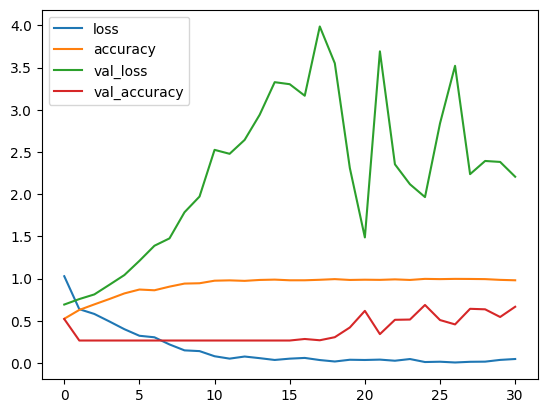

In [6]:
losses = pd.DataFrame(history.history)
losses.plot()

In [7]:
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)
print(classification_report(y_test,y_pred_binary))


11/11 [==============================] - 7s 71ms/step
              precision    recall  f1-score   support

           0       0.74      0.83      0.79       242
           1       0.31      0.20      0.25        88

    accuracy                           0.67       330
   macro avg       0.53      0.52      0.52       330
weighted avg       0.63      0.67      0.64       330

